# Enunciado
## Harry Potter quiere rescatar a su padrino llamado Sirius de la prisi ́on de Azkaban pero para ello tiene que atravesar un camino que tiene fuertes vientos. Ayu ́dalo construyendo un agente inteligente utilizando reinforcement learning para llegar del estado inicial donde se encuentra Harry (S) al estado terminal donde se encuentra Sirius (G).


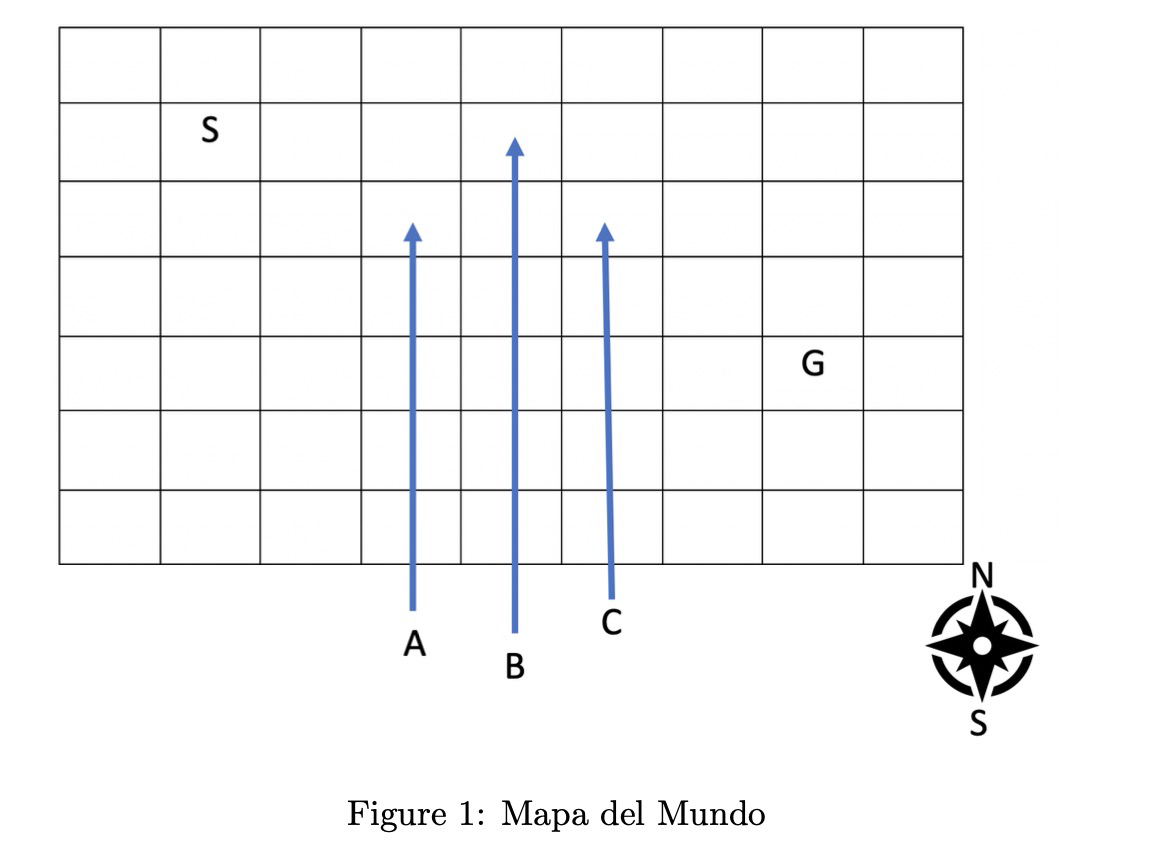

### El mundo es un tablero de 9 columnas y 7 filas. Harry se encuentra en la posici ́on (1,1) y Sirius en la (7,4). Sabes que en las columnas 3( ́o letra A), 4(B) y 5(C) hay fuertes vientos que vienen de sur a norte. Con una probabilidad Pra = 0.9 podr ́ıas terminar una casilla al norte en la columna A, con probabilidad Prb = 0.8 podr ́ıas terminar dos casillas al norte en la columna B y con probabilidad Prc = 0.9 podr ́ıas terminar una casilla al norte en la columna C mientras no te salgas del mapa. Es decir que si Harry se encuentra en la posici ́on (2,1) y ejecuta la acci ́on de avanzar al Este, podr ́ıa terminar con probabilidad P ra en la casilla (3,0) y con probabilidad 1-P ra en la casilla (3,1). El resto de columnas no tiene vientos.
Harry se puede mover en las ocho direcciones del tablero (cuando sea posible) mientras que Sirius no puede moverse.

## ¿Como planeas resolver el problema usando q-learning?

Para resolver el problema utilizando Q-learning, podemos seguir estos pasos:

Definir el entorno: Implementar un entorno personalizado de Gym que represente el tablero con Harry y Sirius. El entorno debe proporcionar métodos para inicializar el estado, tomar acciones, calcular recompensas y determinar la condición de terminación.

Inicializar  Q-table: Crear una tabla Q con dimensiones que correspondan al número de estados y acciones en el entorno. Inicializar los valores de Q en la tabla con valores arbitrarios. (7 * 9)

Definir los parámetros de Q-learning: Establecer el learning rate (alpha), discount factor (gamma), exploration rate (epsilon), y el número de episodios y pasos por episodio.

Algoritmo de Q-learning:

Inicializar el estado actual con el estado inicial del entorno.
Elegir una acción utilizando una estrategia de exploración-explotación (por ejemplo, epsilon-greedy) basada en el estado actual y la tabla Q.
Tomar la acción elegida, observar el siguiente estado y recibir la recompensa del entorno.
Actualizar el valor de Q del par estado-acción actual utilizando la formula de actualización de Q-learning.
Transicionar al siguiente estado y repetir el proceso hasta que se cumpla la condición de terminación. (done = Harry llego a Sirius)
Actualizar la tasa de exploración (epsilon) para disminuir gradualmente la exploración con el tiempo.
Repetir para el número especificado de episodios.
Obtener el optimal-policy: Después de entrenar al agente, extraer el optimal-policy seleccionando la acción con el valor de la Q-table más alto para cada estado. (cada espacio del mapa)

Para trazar la recompensa promedio a lo largo del tiempo, haremos seguimiento de las recompensas obtenidas durante cada episodio y calcularemos la recompensa promedio durante un cierto número de episodios. Graficar esta recompensa promedio contra el número de episodios mostrará cómo mejora el rendimiento del agente con el tiempo.


In [1]:
import numpy as np
import math
import copy
from matplotlib import pyplot as plot
import time
from IPython.display import clear_output



# este (0, 1)
# sureste (1, 1)
# sur (1, 0)
# suroeste (1, -1)
# oeste (0, -1)
# noroeste (-1, -1)
# norte  (-1, 0)
# noreste (-1, 1)


↖ ↑ ↗
← · →
↙ ↓ ↘

In [12]:
class HarryPotterEnv():
    def __init__(self):
        self.map_size = (7, 9)  # Size of the board
        self.harry_pos = (1, 1)  # Initial position of Harry
        self.sirius_pos = (4, 6)  # Position of Sirius
        self.wind_columns = np.array([3, 4, 5]) # Columns with strong winds
        
        self.action_space = np.array([0,1,2,3,4,5,6,7])# Eight possible actions: North, East, South, West, and diagonals
        self.observation_space = self.map_size[0]*self.map_size[1]
     
        
        self.wind_probs = np.array([0.9, 0.8, 0.9])
        
        self.reward_dict = {
            'goal': 100,
            'step': -1,
            'wind':-2,
            'jump off':-500
        }
        
        self.map= None
        self.drawn_map = None
        self.current_state = None

    def create_table(self):
        self.map=np.zeros((self.map_size[0],self.map_size[1]))
        self.drawn_map = np.zeros((self.map_size[0],self.map_size[1]))
        for i in range(0,len(self.map)):
            self.map[i] = [x+i*self.map.shape[1] for x in range(self.map.shape[1])]
    
    def render(self):
      for row_idx in range(self.drawn_map.shape[0]):
        for col_idx in range(self.drawn_map.shape[1]):
            if (row_idx, col_idx) == self.harry_pos:
                symbol = 'H'
            elif (row_idx, col_idx) == self.sirius_pos:
                symbol = 'S'
            else:
                symbol = 'N'
            print(symbol, end=' ')
        print()

    def reset(self):
        self.harry_pos = (1,1)
        self.create_table()
        self.current_state = self.map[self.harry_pos[0]][self.harry_pos[1]]
        return self.current_state
    
    def step(self, action):
        new_state = self._get_next_state(action)
        reward = self._get_reward(new_state)
        done = self._is_terminal_state(new_state)

        if(new_state[0] == -1 or new_state[1]== -1):
            return self.current_state, reward, done

        self.harry_pos = new_state
        self.current_state = self.map[new_state[0]][new_state[1]]
        
        return self.current_state, reward, done
    
    def _get_next_state(self, action):
        directions = [
            (0, 1), (1, 1), (1, 0), (1, -1),
            (0, -1), (-1, -1), (-1, 0), (-1, 1)
        ]

        wind_offsets = [1,2,1]
        
        row, col = self.harry_pos
        direction = directions[action]
        
        new_row = row + direction[0]
        new_col = col + direction[1]
        
        if any(new_col == self.wind_columns):
            index = np.where(new_col == self.wind_columns)
            wind_prob = self.wind_probs[index[0][0]]
            if np.random.rand() <= wind_prob:
                new_row -= wind_offsets[index[0][0]]
                
        if (new_row < 0 or new_row >=7 or new_col < 0 or new_col >=9):
            return (-1,-1)
        
        return (new_row, new_col)
    
    def _get_reward(self, state):
        if state == self.sirius_pos:
            return self.reward_dict['goal']
        elif (any(state[1] == self.wind_columns)):
            return self.reward_dict['wind']
        elif(-1 in state):
            return self.reward_dict['jump off']
        else:
            return self.reward_dict['step']
        
    def random_action(self):
        return np.random.choice(self.action_space)
        
    def _is_terminal_state(self, state):
        if(state == self.sirius_pos):
            return 1  ##goal reached
        if(state[0]==-1 or state[1]==-1):
            return 2 ##jumped off
        return 0 ##Not reached

In [3]:
learning_rate = 0.1  # Learning rate (0 to 1)
discount_rate = 0.95  # Discount factor (0 to 1)
num_episodes = 1000  # Number of episodes
max_steps_per_episode = 100  # Maximum number of steps per episode
rewards_avg = []

env = HarryPotterEnv()

In [4]:

for it in range(100):
    print('average ', it)
    rewards_all_episodes=[]
    
    # exporation-exploitation trade-off params
    exploration_rate = 1
    max_exploration_rate = 1
    min_exploration_rate = 0.01
    exploration_decay_rate = 0.005
    
    q_table = np.zeros((9*7,8))

    # iterate over the episodes
    for episode in range(num_episodes):
        state  = env.reset()
        done = False
        rewards_current_episode = 0
        
        copy_table = copy.deepcopy(q_table)
        
        # iterate over the steps for an episode
        for step in range(max_steps_per_episode):

            # Exploration-explotation trade-off
            exploration_rate_threshold = np.random.uniform(0,1)
            if exploration_rate_threshold <= exploration_rate:
                action = env.random_action()
            else:
                action = np.argmax(q_table[int(state)])

            # Take action
            new_state, reward, done = env.step(action)
            # print(reward)
     
            q_table[int(state), action] = ((1-learning_rate)*copy_table[int(state), action] + learning_rate*(reward+discount_rate*np.max(q_table[int(new_state)])))
            
            # transition next state
            state = new_state
            rewards_current_episode += reward

            if done == 1 or done == 2: 
                break
        
        # Exploration rate decay
        exploration_rate = min_exploration_rate+(max_exploration_rate-min_exploration_rate)*math.exp(-exploration_decay_rate*episode)
        rewards_all_episodes.append(rewards_current_episode)
    rewards_avg.append(rewards_all_episodes)

average  0
average  1
average  2
average  3
average  4
average  5
average  6
average  7
average  8
average  9
average  10
average  11
average  12
average  13
average  14
average  15
average  16
average  17
average  18
average  19
average  20
average  21
average  22
average  23
average  24
average  25
average  26
average  27
average  28
average  29
average  30
average  31
average  32
average  33
average  34
average  35
average  36
average  37
average  38
average  39
average  40
average  41
average  42
average  43
average  44
average  45
average  46
average  47
average  48
average  49
average  50
average  51
average  52
average  53
average  54
average  55
average  56
average  57
average  58
average  59
average  60
average  61
average  62
average  63
average  64
average  65
average  66
average  67
average  68
average  69
average  70
average  71
average  72
average  73
average  74
average  75
average  76
average  77
average  78
average  79
average  80
average  81
average  82
average  83
av

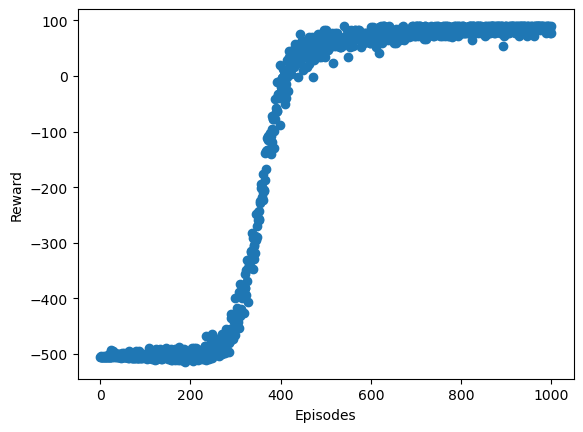

In [5]:
x = [i for i in range(0,num_episodes)]
y = np.mean(rewards_avg, axis=0)
plot.xlabel('Episodes')
plot.ylabel('Reward')
plot.plot(x, y,'o')

In [6]:
q_table

array([[-3.53606834e+00, -3.55672515e+00,  2.65944836e-01,
        -2.04885652e+02, -2.61615654e+02, -2.34990693e+02,
        -2.05093623e+02, -2.85804239e+02],
       [-3.62658299e+00, -3.59712210e+00,  7.13485278e+00,
        -3.56631826e+00, -3.55491997e+00, -3.73903119e+02,
        -3.07588619e+02, -3.59517856e+02],
       [-3.07445464e+02, -3.64682913e+00, -3.66257332e+00,
         5.26523709e+00, -3.67138092e+00, -3.44220458e+02,
        -3.59610514e+02, -3.43961811e+02],
       [-1.98302383e+02, -1.61484326e+02, -3.24202434e+00,
         8.17322659e+00, -3.25640934e+00, -2.05219996e+02,
        -2.61536990e+02, -1.72394466e+02],
       [-1.35878848e+02,  2.41507719e+01, -4.52000000e+01,
        -2.09085924e+00, -1.27213143e+02, -1.35551490e+02,
        -5.00000000e+01, -9.51734925e+01],
       [-7.01818810e-01,  5.33083096e+01, -7.94019975e-01,
        -1.35736826e+02, -8.58826718e+01, -5.00000000e+01,
        -9.50389034e+01, -5.00000000e+01],
       [-3.43900000e-01,  7.005675

In [7]:
for episode in range(10):
    state = env.reset()
    done = False
    print("*****EPISODE ", episode+1, "*****\n\n\n\n")
    time.sleep(1)
    
    for step in range(max_steps_per_episode):        
        clear_output(wait=True)
        env.render()
        time.sleep(1)
        
        action = np.argmax(q_table[int(state),:])        
        new_state, reward, done = env.step(action)
        
        if done:
            clear_output(wait=True)
            env.render()
            if done == 1:
                print("****You reached the goal!****")
                time.sleep(3)
            elif done == 2:
                print("****Did you really just jumped off****")
                time.sleep(3)
                clear_output(wait=True)
            break
            
        state = new_state

N N N N N N N N N 
N N N N N N N N N 
N N N N N N N N N 
N N N N N N N N N 
N N N N N N H N N 
N N N N N N N N N 
N N N N N N N N N 
****You reached the goal!****


####  Dato curioso: Durante el entrenamiento hubo un momento donde no se le penalizo a "Harry" por salirse del mapa, por lo que comprendió que la forma mas rapida de terminar el problema era rendirse y saltar al vacio JAJAJA

In [8]:
total_penalties,total_epochs = 0,0
for episode in range(10):
    state = env.reset()
    epochs,penalties = 0,0
    done = False
    print("*****EPISODE ", episode+1, "*****\n\n\n\n")
    time.sleep(1)
    
    for step in range(max_steps_per_episode):        
        clear_output(wait=True)
        env.render()
        time.sleep(1)
        action = np.argmax(q_table[int(state),:])        
        new_state, reward, done = env.step(action)
        if reward == -500:
            penalties +=1
        epochs +=1
    
        if done:
            clear_output(wait=True)
            env.render()
            if done == 1:
                print("****You reached the goal!****")
                time.sleep(3)
            elif done == 2:
                print("****Did you really just jumped off****")
                time.sleep(3)
                clear_output(wait=True)
            break
        total_penalties += penalties
        total_epochs += epochs   
        state = new_state
        
print(f"Results after {10} episodes:")
print(f"Average timesteps per episode: {total_epochs / 10}")
print(f"Average penalties per episode: {total_penalties / 10}")

N N N N N N N N N 
N N N N N N N N N 
N N N N N N N N N 
N N N N N N N N N 
N N N N N N H N N 
N N N N N N N N N 
N N N N N N N N N 
****You reached the goal!****
Results after 10 episodes:
Average timesteps per episode: 26.7
Average penalties per episode: 0.0


## 2. Encuentra el optimal policy (grafıca una flecha en cada una de las casillas indicando cual es la mejor accion a tomar para esa casilla) y grafica el average reward over time.

In [9]:
import numpy as np
filas = 7
columnas = 9

# Crea una matriz para representar la política óptima
optimal_policy = np.argmax(q_table, axis=1).reshape((filas, columnas))

# Imprime la matriz de política óptima
print(optimal_policy)


[[2 2 3 3 1 1 1 6 2]
 [0 1 3 3 1 0 1 2 3]
 [0 0 1 1 1 1 2 3 3]
 [1 1 1 0 0 1 2 3 4]
 [6 1 1 1 7 0 0 4 3]
 [1 3 6 0 0 1 2 2 4]
 [0 0 7 0 2 1 1 3 2]]


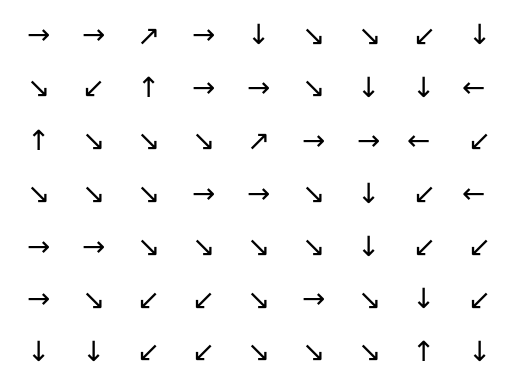

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Crear un grid de 5x5
grid = np.zeros((7, 9))

# Eight possible actions: North, East, South, West, and diagonals
# Crear una matriz de flechas para cada acción
arrows = {0: '→', 1: '↘', 2: '↓', 3: '↙',4:'← ',5:'↖ ',6:'↑',7:'↗'}
# Crear un grid de 5x5
grid = np.zeros((7, 9))
# Crear una figura y un eje
fig, ax = plt.subplots()

ax.grid(color='gray', linewidth=1)

# Iterar sobre cada casilla del grid y agregar una flecha en la dirección correspondiente
for i in range(grid.shape[0]):
    for j in range(grid.shape[1]):
        action = optimal_policy[i][j]
        arrow = arrows[action]
        ax.text(j + 0.5, i + 0.5, arrow,
                ha='center', va='center', fontsize=20)
        ax.set_xlim([0, grid.shape[1]])
        ax.set_ylim([0, grid.shape[0]])
        ax.axis('off')

plt.show()